In [63]:
import numpy as np
from tqdm import tqdm
from mido.midifiles.midifiles import MidiFile
from pathlib import Path

In [64]:
test_file = "/home/os/pro/midi2hands/data/Bach-ItalienischesKonzert.mid"
midi_file = MidiFile(test_file)

In [65]:
print(f"The song has {len(midi_file.tracks)} tracks")

The song has 2 tracks


In [66]:
for track in midi_file.tracks:
    print(f"Track {track.name} has {len(track)} messages")

Track Rechts 16 has 2830 messages
Track Links 16 has 2194 messages


## Midi files
Midi files are a type of file that contains music data.
- Midi files contain events that describe the music, such as note-on, note-off. 
- Each event has a timestamp, which is relative to the previous event.

We want to extract the events from the midi files and convert them to a format that can be used for training a neural network.

In [67]:

class NoteEvent:
    def __init__(self, note: int, velocity: int, start: int, hand: str = None):
        self.note = note
        self.velocity = velocity
        self.start = start
        self.end = None
        self.hand = hand

    def set_end(self, end):
        self.end = end

class MidiEventProcessor:
    """
    The purpose of this class is to extract note events from a midi file.
    The extract_note_events method returns a list of NoteEvent objects.
    """
    def __init__(self):
        self.note_events: list[NoteEvent] = []

    def _create_note_event(self, active_notes, midi_message, timestamp, hand: str):
        note_event = NoteEvent(midi_message.note, midi_message.velocity, timestamp, hand)
        active_notes[midi_message.note] = note_event

    def _process_note_off_event(self, note_events, active_notes, midi_message, timestamp):
        note_event = active_notes.get(midi_message.note)
        if note_event and note_event.end is None:
            note_event.set_end(timestamp)
            note_events.append(note_event)
            active_notes[midi_message.note] = None

    def _process_midi_track(self, note_events: list, midi_track, hand: str):
        cumulative_time = 0  
        active_notes = {}
        for _, midi_message in enumerate(midi_track):
            cumulative_time += midi_message.time
            if midi_message.type == "note_on":
                self._create_note_event(active_notes, midi_message, cumulative_time, hand)
            elif midi_message.type == "note_off":
                self._process_note_off_event(note_events, active_notes, midi_message, cumulative_time)

    def _extract_and_process_midi_tracks(self, midi_file_path) -> list[NoteEvent]:
        note_events = []
        midi_file = MidiFile(midi_file_path)
        for i, midi_track in enumerate(midi_file.tracks):
            hand = "right" if i == 1 else "left"
            self._process_midi_track(note_events, midi_track, hand)
        return sorted(note_events, key=lambda x: x.start)

    def extract_note_events(self, midi_file_path: Path) -> list[NoteEvent]:
        return self._extract_and_process_midi_tracks(midi_file_path)

In [68]:
mp = MidiEventProcessor()
# the events are now sorted by the start time
events = mp.extract_note_events(Path(test_file))
events[:3]

## Preprocessing
Here are multiple ways to represent the events in a window:
- unidirectional? Only take the past events into account.
    - This is the simplest approach.
    - Will not be needed for the final model, since it will only be used with pre recorded data.
- bidirectional? Take both the past and future events into account.
    - Using masked pretraining like a BERT style model?
- Using a windowed approach?
    - Be careful when splitting the data into train test splits.
- one label per window or one label per event?
    - Given seuqnece should one value be outputted or multiple values?
    - Output at each time step or only at the end of the sequence?
- should right hand and left hand be used as a feature?

In [69]:
def preprocess_window(window: list[NoteEvent]):
    """ Convert the list of notes to a numpy array, also normalize the start times """
    window = np.array([(n.note, n.velocity, n.start) for n in window], dtype=np.float32)
    window[:, 2] = window[:, 2] / window[-1, 2]
    return window

def extract_windows_and_labels(events, window_size, step_size, bidirectional=False):
    windows = []
    labels = []
    for i in range(0, len(events) - window_size, step_size):
        window = events[i:i + window_size]
        windows.append(preprocess_window(window))
        if bidirectional:
            n: NoteEvent = window[window_size // 2]
            label = 0 if n.hand == "left" else 1
            labels.append(label)
        else:
            n: NoteEvent = window[-1]
            label = 0 if n.hand == "left" else 1
            labels.append(label)
    return windows, labels

In [70]:
windows, labels = extract_windows_and_labels(events, window_size=30, step_size=1, bidirectional=False)

print(f"number of windows: {len(windows)}")
print(f"window shape: {windows[0].shape}")
print(f"window label: {labels[0]}")

number of windows: 2472
window shape: (30, 3)
window label: 0


In [71]:
# now we want to extract windows from all files
import os
mp = MidiEventProcessor()

all_windows = []
all_labels = []

for file in tqdm(os.listdir("data")):
    if not file.endswith(".mid"):
        continue
    path = os.path.join("data", file)
    # extract events
    events = mp.extract_note_events(Path(path))
    # convert to windows and labels
    windows, labels = extract_windows_and_labels(events, window_size=30, step_size=1, bidirectional=False)
    all_windows.extend(windows)
    all_labels.extend(labels)
    # concatenate

all_windows = np.array(all_windows)
all_labels = np.array(all_labels)

print(all_windows.shape)
print(all_labels.shape)



100%|██████████| 122/122 [00:11<00:00, 11.05it/s]


(339667, 30, 3)
(339667,)


In [72]:
print(len(windows), len(labels))

484 484


In [73]:
class MidiDataset:
    def __init__(self, windows, labels):
        self.windows = windows
        self.labels = labels

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

In [74]:
# create a data loader
from torch.utils.data import DataLoader, random_split

batch_size = 64
dataset = MidiDataset(all_windows, all_labels)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])
# split dataset in train and validation
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [75]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=3, hidden_size=16, num_layers=2, num_classes=1).to(device)

example = next(iter(train_loader))
events = example[0].to(device)
print(model(events).shape)
print(example[1].unsqueeze(1).shape)

torch.Size([64, 1])
torch.Size([64, 1])


In [76]:
# hyperparameters
num_epochs = 20
input_size = 3
hidden_size = 16
num_layers = 2
num_classes = 1

In [77]:

# model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
accuracies = []
val_accuracies = []
all_acc = []

def accuracy(y_true: list[int], y_pred: list[int]):
    return np.mean(np.array(y_true) == np.array(y_pred))


for epoch in range(num_epochs):
    epoch_losses = []
    y_true = []
    y_pred = []
    for i, (windows, labels) in tqdm(enumerate(train_loader), total=len(train_loader), unit="batch"):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        # Forward pass
        outputs = model(windows)
        loss = criterion(outputs, labels)

        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        all_acc.append(accuracy(y_t, y_p))

        y_true.extend(y_t)
        y_pred.extend(y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses))
    accuracies.append(accuracy(y_true, y_pred))

    # validation
    y_true = []
    y_pred = []
    for i, (windows, labels) in enumerate(val_loader):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        outputs = model(windows)
        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        y_true.extend(y_t)
        y_pred.extend(y_p)

    val_accuracies.append(accuracy(y_true, y_pred))


  0%|          | 0/5308 [00:00<?, ?batch/s]

100%|██████████| 5308/5308 [00:08<00:00, 615.29batch/s]


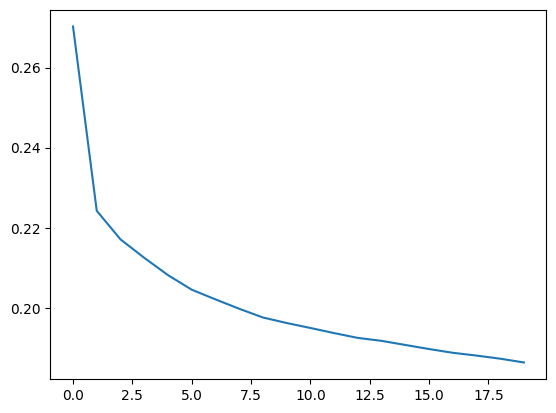

In [78]:
import matplotlib.pyplot as plt
plt.plot(losses)

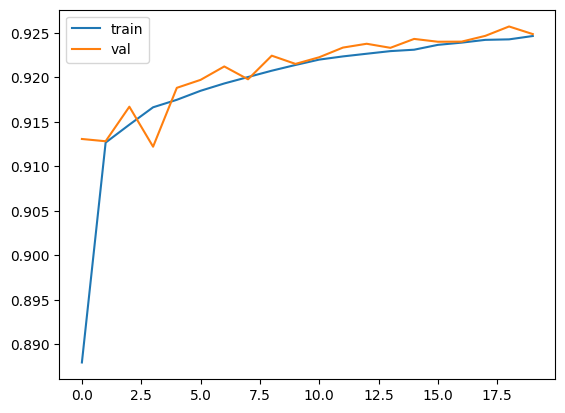

In [79]:
fig, ax = plt.subplots()

ax.plot(accuracies, label="train")
ax.plot(val_accuracies, label="val")
ax.legend()

